***

<h1 align="center" style="font-weight:bold">DTSA 5510 Final Project</h1>
<h2 align="center" style="font-weight:bold">Stock Portfolio Diversification Tool</h2>
<h3 align="center">by Ryan Ordonez</h3>

### Elevator Pitch: 
Imagine a tool that takes the guesswork out of building a stock portfolio, making investing easy and accessible. A well-diversified portfolio is crucial for managing risk and maximizing potential returns, and my tool ensures that your investments are spread across a range of stocks to achieve just that. With just a few clicks, you can determine how much risk you’re comfortable with and your growth goals. My tool then uses powerful machine learning to analyze a wide range of stocks and recommend a personalized, diversified portfolio tailored just for you. Whether you're a young investor looking for aggressive growth or someone who wants a balanced strategy, this tool helps you make confident, informed decisions effortlessly.

### Project Description: 
This project aims to create a personalized stock portfolio recommendation tool using unsupervised machine learning. It will provide you with investment options that are diversified and tailored to your specific needs. By taking the guesswork out of portfolio building, this tool helps you make informed investment decisions with confidence. The tool starts by analyzing a dataset of stocks to understand key characteristics such as sector, historical performance, and price trends. This understanding is crucial for identifying patterns and opportunities. The goal is to create a portfolio that balances risk and reward according to your personal preferences, making investing more accessible and effective. With a focus on personalization, this project aims to empower you to make confident decisions without the complexity often associated with stock investing. 

The project includes several technical steps to achieve its goals. First, Exploratory Data Analysis (EDA) is conducted to thoroughly understand the dataset, including analyzing stock data such as sector distributions, price trends, and historical performance to identify patterns and outliers. Next, feature engineering is applied to calculate metrics like historical volatility and average returns, which enhance the effectiveness of clustering. The K-Means clustering algorithm is then used to group stocks with similar attributes, helping to segment stocks into distinct groups for well-diversified and strategic investment recommendations. After clustering, I interpret and analyze the characteristics of each cluster to better understand the similarities within each group. Based on the clusters and your input, I generate a personalized portfolio tailored to your preferences, ensuring alignment with your risk tolerance and growth strategy. Finally, I backtest the portfolio against historical data to evaluate its performance and ensure it meets your investment goals.

***

#### Install Needed Packages

In [445]:
%pip install yfinance > NUL

Note: you may need to restart the kernel to use updated packages.


#### Import the Necessary Libraries

In [446]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random

# Set pandas options to display more columns and increase the display width
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame
pd.set_option('display.width', 1000)        # Set the display width to a large number
pd.set_option('display.max_colwidth', None) # Prevent column content from being truncated

#### Load the dataset
This dataset was created with the 100 highest market cap stocks in each of the 11 sectors.

In [447]:
url = 'https://raw.githubusercontent.com/RyanOrdonez/Final_Project_DTSA5510/refs/heads/main/StockList.csv'
stock_data = pd.read_csv(url)

#### Display the first few rows to ensure it loaded correctly

In [448]:
print(stock_data.head())

  Symbol                   Name Price (Intraday) Market Cap PE Ratio (TTM)      Sector
0   AAPL             Apple Inc.           227.55      3.46T          34.58  Technology
1   NVDA     NVIDIA Corporation            134.8     3.307T          63.29  Technology
2   MSFT  Microsoft Corporation           416.32     3.095T          35.34  Technology
3   AVGO          Broadcom Inc.           181.48   847.617B         147.54  Technology
4   ORCL     Oracle Corporation           175.77   487.069B           45.3  Technology


***

#### User input Section
A user will enter their desired Risk Tolerance level and their preferred Growth Strategy. 

In [449]:
# Function to collect user input for risk tolerance and growth strategy
def get_user_inputs():
    try:
        # Collect user's risk tolerance (1 for low, 2 for medium, 3 for high)
        print("Please select your risk tolerance:")
        risk_tolerance_input = int(input("Enter 1 for Low Risk, 2 for Medium Risk, 3 for High Risk: "))
        
        if risk_tolerance_input == 1:
            risk_tolerance = 'low'
        elif risk_tolerance_input == 2:
            risk_tolerance = 'medium'
        elif risk_tolerance_input == 3:
            risk_tolerance = 'high'
        else:
            raise ValueError("Invalid choice for risk tolerance.")
        
        # Collect user's growth strategy (1 for conservative, 2 for balanced, 3 for aggressive)
        print("Please select your growth strategy:")
        growth_strategy_input = int(input("Enter 1 for Conservative, 2 for Balanced, 3 for Aggressive: "))

        if growth_strategy_input == 1:
            growth_strategy = 'conservative'
        elif growth_strategy_input == 2:
            growth_strategy = 'balanced'
        elif growth_strategy_input == 3:
            growth_strategy = 'aggressive'
        else:
            raise ValueError("Invalid choice for growth strategy.")

        return risk_tolerance, growth_strategy

    except ValueError as e:
        print(f"Invalid input: {e}")
        return get_user_inputs()

# Get the user inputs
risk_tolerance, growth_strategy = get_user_inputs()

# Print the collected inputs to ensure everything is working
print(f"Your selected Risk Tolerance Level is: {risk_tolerance}")
print(f"Your selected Growth Strategy is: {growth_strategy}")

Please select your risk tolerance:
Please select your growth strategy:
Your selected Risk Tolerance Level is: low
Your selected Growth Strategy is: aggressive


***

#### Pull in historical stock price data
I will pull in the historical prices for each of the stocks to be able to do feature engineering. I will then merge the datasets together and drop irrellavent columns. 

In [450]:
# Load the stock data to get ticker symbols
tickers = stock_data['Symbol'].unique()

# Define the date range
start_date = "2019-10-01"
end_date = "2024-10-01"

# Fetch historical data every three months for each stock
historical_data = []

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        # Pull historical data with quarterly frequency ('3mo')
        temp_df = stock.history(start=start_date, end=end_date, interval="3mo")
        # Add the stock symbol as a column
        temp_df['symbol'] = ticker
        # Append the dataframe to the list
        historical_data.append(temp_df)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Concatenate the list of dataframes into a single dataframe
historical_df = pd.concat(historical_data)

# Reset index for cleaner handling
historical_df.reset_index(inplace=True)

# Rename the 'Symbol' column in stock_data to match 'symbol' in historical_df
stock_data.rename(columns={'Symbol': 'symbol'}, inplace=True)

# Merge historical_df and stock_data on 'symbol'
merged_df = pd.merge(historical_df, stock_data, on='symbol', how='left')

# Drop unnecessary columns
columns_to_drop = ['Open', 'High', 'Low', 'Stock Splits', 'Price (Intraday)', 'PE Ratio (TTM)']
final_merged_df = merged_df.drop(columns=columns_to_drop)

# Convert the 'Date' column to show only month and year
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date']).dt.to_period('M')

C:\Users\Ryan Ordonez\AppData\Local\Temp\ipykernel_22128\2491395273.py:40: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date']).dt.to_period('M')


***

### Data Cleaning

I will now check for missing values. 

In [451]:
# Check for missing values in final_merged_df
missing_values = final_merged_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Summary statistics for numerical columns in final_merged_df
summary_stats = final_merged_df.describe()
print("\nSummary statistics:")
print(summary_stats)

Missing values in each column:
Date           0
Close          0
Volume         0
Dividends      0
symbol         0
Name          20
Market Cap    20
Sector         0
dtype: int64

Summary statistics:
              Close        Volume     Dividends
count  20647.000000  2.064700e+04  20647.000000
mean     112.878487  2.455243e+08      0.364906
std      248.408268  1.051849e+09      0.717896
min        0.186741  0.000000e+00      0.000000
25%       26.466508  3.215185e+07      0.000000
50%       57.851509  8.135150e+07      0.195000
75%      124.156681  1.902970e+08      0.500000
max     9811.799805  3.576470e+10     35.000000


I see that there are some values missing in the Name and Market Cap column, I will drop those as it won't contribute meaningfully to the results. 

In [452]:
# Drop rows where 'Name' or 'Market Cap' is missing
final_merged_df.dropna(subset=['Name', 'Market Cap'], inplace=True)

***

### Feature Engineering

I will calculate price trends as a percentage change from the last available quarter and also show the stock volatility. 

In [453]:
final_merged_df['quarterly_return'] = final_merged_df.groupby('symbol')['Close'].pct_change(periods=1)
final_merged_df['volatility'] = final_merged_df.groupby('symbol')['quarterly_return'].rolling(window=4).std().reset_index(level=0, drop=True)

# Display the updated dataframe with quarterly_returns and volatility
print(final_merged_df[['symbol', 'Date', 'quarterly_return', 'volatility']].head())

  symbol     Date  quarterly_return  volatility
0   AAPL  2019-10               NaN         NaN
1   AAPL  2020-01         -0.131437         NaN
2   AAPL  2020-04          0.437987         NaN
3   AAPL  2020-07          0.273284         NaN
4   AAPL  2020-10          0.147822    0.240329


In [454]:
# Classify stocks based on quarterly returns for growth strategy
final_merged_df['growth_level'] = pd.cut(final_merged_df['quarterly_return'], 
                                         bins=[-float('inf'), 0.04, 0.1, float('inf')], 
                                         labels=['conservative', 'balanced', 'aggressive'])

# Classify stocks based on volatility for risk level
final_merged_df['risk_level'] = pd.cut(final_merged_df['volatility'], 
                                       bins=[-float('inf'), 0.2, 0.3, float('inf')], 
                                       labels=['low', 'medium', 'high'])

# Display the dataframe with growth and risk levels
print(final_merged_df[['symbol', 'Date', 'growth_level', 'risk_level']].head())

  symbol     Date  growth_level risk_level
0   AAPL  2019-10           NaN        NaN
1   AAPL  2020-01  conservative        NaN
2   AAPL  2020-04    aggressive        NaN
3   AAPL  2020-07    aggressive        NaN
4   AAPL  2020-10    aggressive     medium


In [455]:
# Ensure 'Date' is in a proper datetime format
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'].astype(str), errors='coerce')

In [456]:
# Check and convert 'Close' to numeric (if needed)
final_merged_df['Close'] = pd.to_numeric(final_merged_df['Close'], errors='coerce')

# Ensure 'growth_level' is categorical
final_merged_df['growth_level'] = final_merged_df['growth_level'].astype('category')

# Ensure 'risk_level' is categorical (if you plan to use it for the risk level plot)
final_merged_df['risk_level'] = final_merged_df['risk_level'].astype('category')

***

#### I would like to visualize a few stock charts including AAPL to see if everything looks correct. 

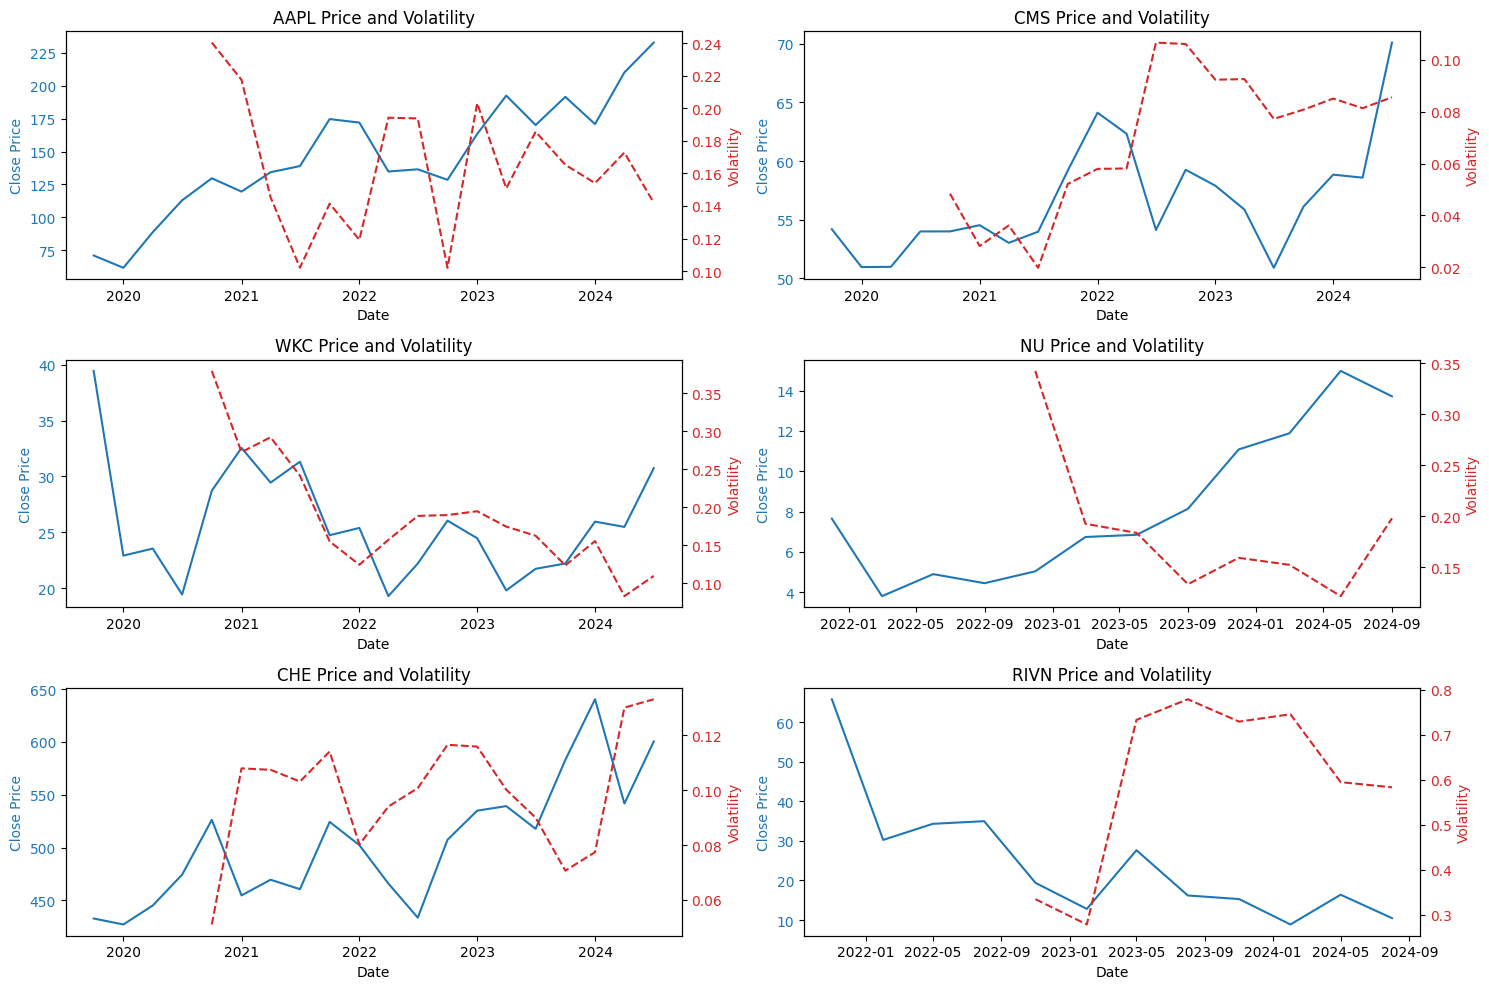

In [457]:
# Select 6 random stocks, including Apple
selected_stocks = ['AAPL'] + random.sample(list(final_merged_df['symbol'].unique()), 5)

# Create a 2x3 grid of plots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot price and volatility for each stock
for i, stock in enumerate(selected_stocks):
    stock_df = final_merged_df[final_merged_df['symbol'] == stock]
    
    ax1 = axes[i]
    ax2 = ax1.twinx()  # Create a second y-axis for volatility
    
    # Plot price trend (Close price)
    ax1.set_title(f'{stock} Price and Volatility')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='tab:blue')
    ax1.plot(stock_df['Date'], stock_df['Close'], color='tab:blue', label='Close Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot volatility
    ax2.set_ylabel('Volatility', color='tab:red')
    ax2.plot(stock_df['Date'], stock_df['volatility'], color='tab:red', linestyle='--', label='Volatility')
    ax2.tick_params(axis='y', labelcolor='tab:red')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

***

Aggregate the Data: We’ll group the data by stock (symbol) and take the mean of quarterly_return and volatility.

In [459]:
# Step 1: Aggregate the data by stock symbol
# Taking the mean of 'quarterly_return' and 'volatility' for each stock
aggregated_data = final_merged_df.groupby('symbol').agg({
    'quarterly_return': 'mean',
    'volatility': 'mean',
    'Name': 'first',
    'Market Cap': 'first'
}).reset_index()

# Drop any rows with missing values
aggregated_data = aggregated_data.dropna()

# Display the first few rows to confirm aggregation
print(aggregated_data.head())


  symbol  quarterly_return  volatility                        Name Market Cap
0      A          0.040379    0.127773  Agilent Technologies, Inc.    41.324B
1     AA          0.118565    0.321687           Alcoa Corporation    10.597B
2   AAPL          0.077665    0.164332                  Apple Inc.      3.46T
3   ABBV          0.064248    0.149137                 AbbVie Inc.   343.006B
4   ABNB         -0.013980    0.162433                Airbnb, Inc.    84.998B


In [460]:
print(aggregated_data.describe())

       quarterly_return   volatility
count       1059.000000  1059.000000
mean           0.057849     0.190006
std            0.219964     0.509898
min           -0.092895     0.035758
25%            0.021488     0.119010
50%            0.041799     0.152723
75%            0.070108     0.206428
max            7.003422    16.504851


***

Model

Step 1: Identify Outliers in `quarterly_return` and `volatility`

In this step, we identify outliers in the `quarterly_return` and `volatility` columns using the Interquartile Range (IQR) method. Outliers are values that fall below 1.5 * IQR from the 25th percentile or above the 75th percentile.

In [461]:
# Step 1: Identify outliers using IQR method for quarterly_return and volatility
Q1_quarterly_return = aggregated_data['quarterly_return'].quantile(0.25)
Q3_quarterly_return = aggregated_data['quarterly_return'].quantile(0.75)
IQR_quarterly_return = Q3_quarterly_return - Q1_quarterly_return

Q1_volatility = aggregated_data['volatility'].quantile(0.25)
Q3_volatility = aggregated_data['volatility'].quantile(0.75)
IQR_volatility = Q3_volatility - Q1_volatility

# Define bounds for quarterly_return and volatility
lower_bound_quarterly_return = Q1_quarterly_return - 1.5 * IQR_quarterly_return
upper_bound_quarterly_return = Q3_quarterly_return + 1.5 * IQR_quarterly_return

lower_bound_volatility = Q1_volatility - 1.5 * IQR_volatility
upper_bound_volatility = Q3_volatility + 1.5 * IQR_volatility

Step 2: Remove Outliers
In this step, we filter out the rows that contain outliers in quarterly_return and volatility. This will leave us with a "cleaned" dataset for clustering.

In [462]:
# Step 2: Remove outliers
cleaned_data = aggregated_data[
    (aggregated_data['quarterly_return'] >= lower_bound_quarterly_return) & 
    (aggregated_data['quarterly_return'] <= upper_bound_quarterly_return) &
    (aggregated_data['volatility'] >= lower_bound_volatility) & 
    (aggregated_data['volatility'] <= upper_bound_volatility)
]

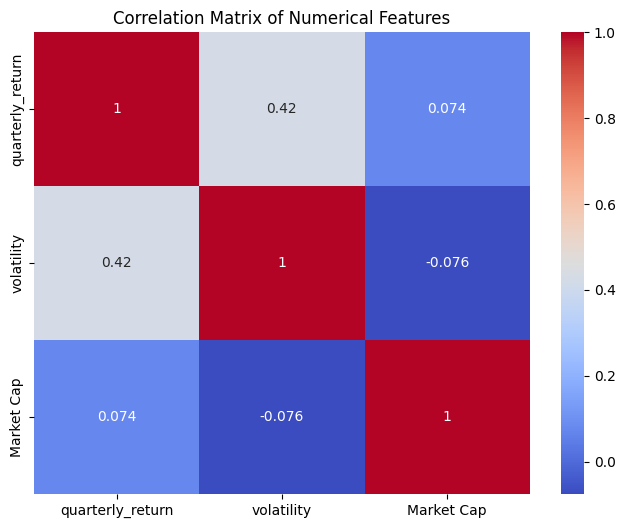

In [567]:
# Function to convert 'Market Cap' strings to numeric values, including 'T' for trillions
def convert_market_cap(market_cap_str):
    if isinstance(market_cap_str, str):
        market_cap_str = market_cap_str.strip()
        if market_cap_str.endswith('T'):
            return float(market_cap_str[:-1]) * 1e12
        elif market_cap_str.endswith('B'):
            return float(market_cap_str[:-1]) * 1e9
        elif market_cap_str.endswith('M'):
            return float(market_cap_str[:-1]) * 1e6
        elif market_cap_str.endswith('K'):
            return float(market_cap_str[:-1]) * 1e3
        else:
            # If no recognized suffix, attempt to convert directly
            return float(market_cap_str)
    else:
        return market_cap_str

# Apply the conversion function
cleaned_data['Market Cap'] = cleaned_data['Market Cap'].apply(convert_market_cap)

# Ensure 'Market Cap' is numeric
cleaned_data['Market Cap'] = pd.to_numeric(cleaned_data['Market Cap'], errors='coerce')

# Drop any rows with NaN values in 'Market Cap'
cleaned_data = cleaned_data.dropna(subset=['Market Cap'])

# Compute the correlation matrix
correlation_matrix = cleaned_data[['quarterly_return', 'volatility', 'Market Cap']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


Analysis: 
- Quarterly Return and Volatility (0.42): There is a moderate positive correlation (0.42) between quarterly return and volatility. This suggests that stocks with higher volatility tend to have higher returns, but the relationship is not extremely strong.

- Quarterly Return and Market Cap (0.074): There is a very weak positive correlation (0.074) between quarterly return and market cap. This indicates that larger market cap stocks are slightly associated with higher returns, but the effect is minimal.

- Volatility and Market Cap (-0.076): There is a weak negative correlation (-0.076) between volatility and market cap. This suggests that larger companies tend to have slightly lower volatility, but again, the relationship is very weak.

***

Step 3: Apply K-Means Clustering on the Cleaned Data
Next, we perform K-Means clustering on the cleaned data. We scale the features (quarterly_return and volatility) before applying K-Means to ensure that both features are on the same scale.

In [464]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_data[['quarterly_return', 'volatility']])

# Apply K-Means
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_features)

# Assign cluster labels to the cleaned data
cleaned_data['cluster'] = kmeans.labels_

Step 4: Visualize the Clusters
We now create a scatter plot to visualize the clusters formed by the K-Means algorithm based on quarterly_return and volatility.

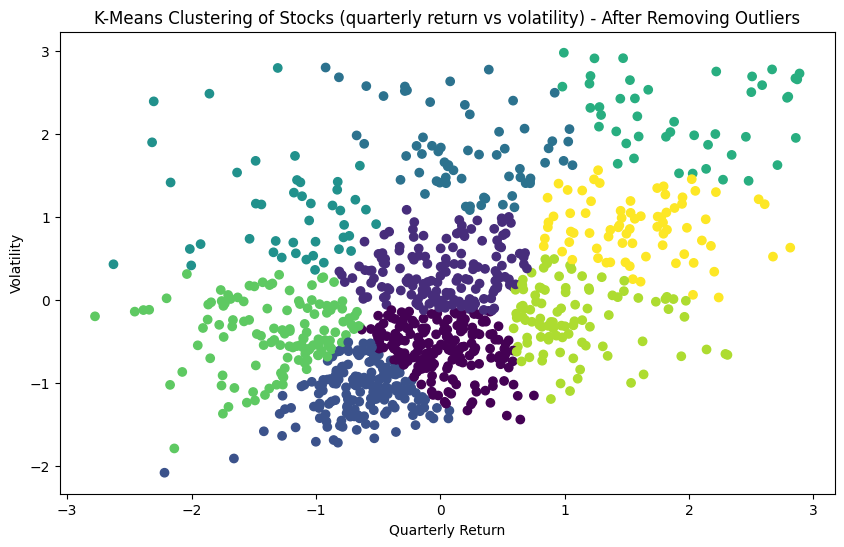

In [465]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Quarterly Return')
plt.ylabel('Volatility')
plt.title('K-Means Clustering of Stocks (quarterly return vs volatility) - After Removing Outliers')
plt.show()

***

Assign Labels: Based on the characteristics of the cluster centers, we can assign intuitive labels such as "Low Risk, High Growth" or "High Risk, Low Growth" depending on their relative positions on the plot.

In [466]:
# Step 1: Analyze cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers (actual values):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Quarterly Return = {center[0]:.2f}, Volatility = {center[1]:.2f}")

# Define the labels for the 9 clusters
labels = [
    'Low Growth - Low Risk', 'Low Growth - Moderate Risk', 'Low Growth - High Risk',
    'Moderate Growth - Low Risk', 'Moderate Growth - Moderate Risk', 'Moderate Growth - High Risk',
    'High Growth - Low Risk', 'High Growth - Moderate Risk', 'High Growth - High Risk'
]

# Assign the labels to each stock in the dataframe
cleaned_data.loc[:, 'cluster_label'] = cleaned_data['cluster'].map({i: labels[i] for i in range(num_clusters)}).copy()

# Step 4: Explore stocks in each cluster
for i in range(num_clusters):
    print(f"\nCluster {i} ({labels[i]}):")
    print(cleaned_data[cleaned_data['cluster'] == i].head()[['symbol', 'quarterly_return', 'volatility']])


Cluster Centers (actual values):
Cluster 0: Quarterly Return = 0.04, Volatility = 0.12
Cluster 1: Quarterly Return = 0.04, Volatility = 0.18
Cluster 2: Quarterly Return = 0.02, Volatility = 0.10
Cluster 3: Quarterly Return = 0.05, Volatility = 0.26
Cluster 4: Quarterly Return = 0.00, Volatility = 0.22
Cluster 5: Quarterly Return = 0.11, Volatility = 0.29
Cluster 6: Quarterly Return = -0.00, Volatility = 0.13
Cluster 7: Quarterly Return = 0.08, Volatility = 0.15
Cluster 8: Quarterly Return = 0.10, Volatility = 0.21

Cluster 0 (Low Growth - Low Risk):
   symbol  quarterly_return  volatility
0       A          0.040379    0.127773
7    ACGL          0.062196    0.130072
9     ACM          0.059442    0.130504
10    ACN          0.041799    0.120325
13    ADI          0.050055    0.125696

Cluster 1 (Low Growth - Moderate Risk):
   symbol  quarterly_return  volatility
8     ACI          0.054296    0.170532
11   ADBE          0.037726    0.155067
20    AES          0.024996    0.179901
29 

***

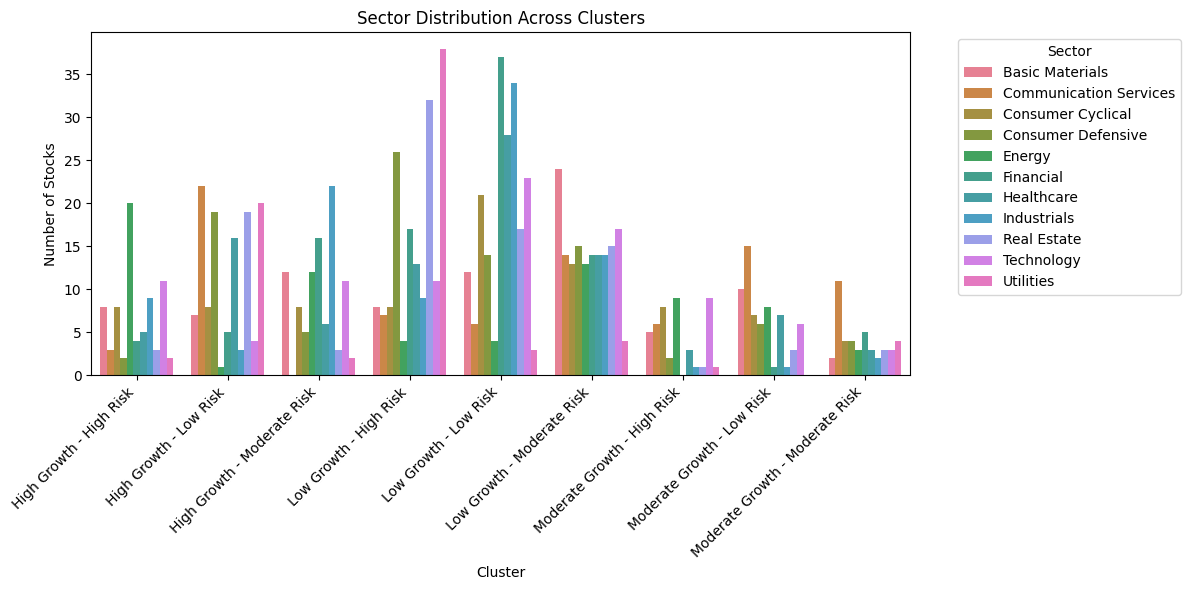

In [467]:
# Merge sector information from stock_data if it's missing in cleaned_data
if 'sector' not in cleaned_data.columns:
    cleaned_data = pd.merge(cleaned_data, stock_data[['symbol', 'Sector']], left_on='symbol', right_on='symbol', how='left')
    cleaned_data.rename(columns={'Sector': 'sector'}, inplace=True)
    
# Group by cluster_label and sector, then count how many stocks are in each group
sector_distribution = cleaned_data.groupby(['cluster_label', 'sector']).size().reset_index(name='stock_count')

# Visualize sector distribution by cluster label with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster_label', y='stock_count', hue='sector', data=sector_distribution)
plt.title('Sector Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Stocks')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [468]:
# Check if 'growth_level' and 'risk_level' columns exist
print(cleaned_data.columns)

# Classify stocks based on adjusted price trend for growth strategy
cleaned_data['growth_level'] = pd.cut(cleaned_data['quarterly_return'], 
                                      bins=[-float('inf'), 0.02, 0.06, float('inf')], 
                                      labels=['conservative', 'balanced', 'aggressive'])

# Classify stocks based on adjusted volatility for risk level
cleaned_data['risk_level'] = pd.cut(cleaned_data['volatility'], 
                                    bins=[-float('inf'), 0.12, 0.19, float('inf')], 
                                    labels=['low', 'medium', 'high'])

# Confirm that the classification worked
print(cleaned_data[['symbol', 'growth_level', 'risk_level']].head())


Index(['symbol', 'quarterly_return', 'volatility', 'Name', 'Market Cap', 'cluster', 'cluster_label', 'sector'], dtype='object')
  symbol  growth_level risk_level
0      A      balanced     medium
1     AA    aggressive       high
2   AAPL    aggressive     medium
3   ABBV    aggressive     medium
4   ABNB  conservative     medium


***

Visualization of Distribution of stocks by Risk and Growth Levels. 

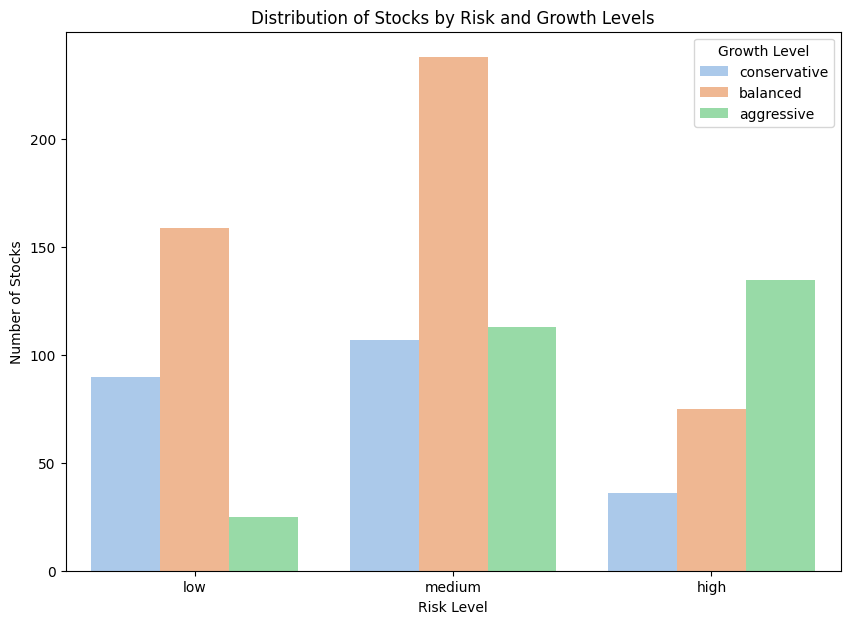

In [469]:
# Ensure that 'risk_level' and 'growth_level' are categorical types with a specific order
risk_order = ['low', 'medium', 'high']
growth_order = ['conservative', 'balanced', 'aggressive']

cleaned_data['risk_level'] = pd.Categorical(cleaned_data['risk_level'], categories=risk_order, ordered=True)
cleaned_data['growth_level'] = pd.Categorical(cleaned_data['growth_level'], categories=growth_order, ordered=True)

# Distribution of Stocks by Risk Level and Growth Level
plt.figure(figsize=(10, 7))
sns.countplot(data=cleaned_data, x='risk_level', hue='growth_level', order=risk_order, hue_order=growth_order, palette='pastel')
plt.title('Distribution of Stocks by Risk and Growth Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Stocks')
plt.legend(title='Growth Level')
plt.show()

***

### Portfolio Creation Section
Here is where we put it all together and generate a portfolio for the user based on his/her desired risk and growth strategy. 

In [557]:
# Step 1: Filter stocks based on user inputs
filtered_stocks = cleaned_data[
    (cleaned_data['risk_level'] == risk_tolerance) &
    (cleaned_data['growth_level'] == growth_strategy)
]

# Step 2: Check the number of unique sectors in the filtered stocks
unique_sectors = filtered_stocks['sector'].unique()
num_sectors = len(unique_sectors)

# If there are less than 8 sectors, we need to adjust our criteria
if num_sectors < 8:
    print("Not enough sectors found with the exact criteria. Expanding search criteria.")
    # Define the order of risk levels and growth strategies
    risk_levels = ['low', 'medium', 'high']
    growth_strategies = ['conservative', 'balanced', 'aggressive']
    
    # Get the indices of the user's choices
    risk_index = risk_levels.index(risk_tolerance)
    growth_index = growth_strategies.index(growth_strategy)
    
    # Create lists of acceptable risk levels and growth strategies by including adjacent levels
    acceptable_risk_levels = [risk_tolerance]
    if risk_index > 0:
        acceptable_risk_levels.append(risk_levels[risk_index - 1])
    if risk_index < len(risk_levels) - 1:
        acceptable_risk_levels.append(risk_levels[risk_index + 1])
    
    acceptable_growth_strategies = [growth_strategy]
    if growth_index > 0:
        acceptable_growth_strategies.append(growth_strategies[growth_index - 1])
    if growth_index < len(growth_strategies) - 1:
        acceptable_growth_strategies.append(growth_strategies[growth_index + 1])
    
    # Re-filter stocks with the expanded criteria
    filtered_stocks = cleaned_data[
        (cleaned_data['risk_level'].isin(acceptable_risk_levels)) &
        (cleaned_data['growth_level'].isin(acceptable_growth_strategies))
    ]
    
    # Update the number of unique sectors
    unique_sectors = filtered_stocks['sector'].unique()
    num_sectors = len(unique_sectors)

# Step 3: Ensure we have at least 8 sectors
if num_sectors >= 8:
    # Randomly select 8 sectors
    selected_sectors = np.random.choice(unique_sectors, 8, replace=False)
else:
    # Use all available sectors if less than 8
    selected_sectors = unique_sectors

# Step 4: Select at least one stock from each selected sector
portfolio_stocks = pd.DataFrame()
for sector in selected_sectors:
    sector_stocks = filtered_stocks[filtered_stocks['sector'] == sector]
    if not sector_stocks.empty:
        selected_stock = sector_stocks.sample(n=1)
        portfolio_stocks = pd.concat([portfolio_stocks, selected_stock])

# Step 5: Fill the remaining slots to reach 20 stocks
remaining_slots = 20 - len(portfolio_stocks)
remaining_stocks = filtered_stocks[
    ~filtered_stocks['symbol'].isin(portfolio_stocks['symbol'])
]

if len(remaining_stocks) >= remaining_slots:
    additional_stocks = remaining_stocks.sample(n=remaining_slots)
else:
    # If not enough stocks, include stocks from the broader dataset
    additional_stocks_needed = remaining_slots - len(remaining_stocks)
    additional_stocks = remaining_stocks
    extra_stocks = cleaned_data[
        ~cleaned_data['symbol'].isin(portfolio_stocks['symbol'])
    ].sample(n=additional_stocks_needed)
    additional_stocks = pd.concat([additional_stocks, extra_stocks])

# Combine the selected stocks to form the final portfolio
portfolio_stocks = pd.concat([portfolio_stocks, additional_stocks]).head(20)

# Display the recommended portfolio
print("\nYour Recommended Portfolio:")
print(portfolio_stocks[['symbol', 'Name', 'sector', 'quarterly_return', 'volatility', 'risk_level', 'growth_level']])



Your Recommended Portfolio:
    symbol                            Name              sector  quarterly_return  volatility risk_level growth_level
671   ORLY       O'Reilly Automotive, Inc.   Consumer Cyclical          0.062218    0.110670        low   aggressive
467    IRM      Iron Mountain Incorporated         Real Estate          0.095434    0.099785        low   aggressive
595   MSFT           Microsoft Corporation          Technology          0.063308    0.115125        low   aggressive
271    DTM              DT Midstream, Inc.              Energy          0.061695    0.076436        low   aggressive
434   HWKN                   Hawkins, Inc.     Basic Materials          0.109070    0.118755        low   aggressive
637    NRG                NRG Energy, Inc.           Utilities          0.065685    0.115095        low   aggressive
313    ETN           Eaton Corporation plc         Industrials          0.080940    0.102768        low   aggressive
196   COST    Costco Wholesale Corp

***

#### Backtesting your Portfolio!
Here I will evaluate the portfolio to determine if the selected stocks would have generated a decent return on investment for you depending on your risk and growth levels. 

In [558]:
# Get the list of stock symbols in the recommended portfolio
portfolio_symbols = portfolio_stocks['symbol'].tolist()

# Define the backtesting period
# For example, the last 3 years
backtest_start_date = "2021-10-01"
backtest_end_date = "2024-10-01"

# Fetch historical daily price data for portfolio stocks
portfolio_historical_data = yf.download(
    tickers=portfolio_symbols,
    start=backtest_start_date,
    end=backtest_end_date,
    interval='1d',  # Daily data
    group_by='ticker',
    auto_adjust=True,  # Adjust for splits and dividends
    threads=True
)

# Check if data was fetched successfully
print("Historical data fetched for portfolio stocks.")


[*********************100%%**********************]  20 of 20 completed

Historical data fetched for portfolio stocks.


This is to calculate the daily returns for the selected stocks in the portfolio.

In [559]:
# Initialize an empty DataFrame to hold returns
stock_returns = pd.DataFrame()

# Loop through each stock and calculate daily returns
for symbol in portfolio_symbols:
    # Extract the 'Close' price for the stock
    stock_data = portfolio_historical_data[symbol]['Close']
    # Calculate daily returns
    stock_return = stock_data.pct_change().dropna()
    # Add the returns to the DataFrame
    stock_returns[symbol] = stock_return

# Display the first few rows of stock returns
print(stock_returns.head())


                ORLY       IRM      MSFT       DTM      HWKN       NRG       ETN      COST       SUN       AZO      MUSA       HLI       BRO      RYAN       APH      TTEK      ARES       JEF       MCK       MSI
Date                                                                                                                                                                                                              
2021-10-04 -0.010191  0.004776 -0.020720  0.007000 -0.008715 -0.008116 -0.015201 -0.018268  0.017676 -0.017802  0.004512  0.015195 -0.007292 -0.018502 -0.014341 -0.004610 -0.015854  0.001055 -0.000300 -0.012121
2021-10-05  0.015611  0.001584  0.019957  0.006952  0.012912  0.014134  0.019547  0.013859  0.000263  0.005303 -0.029904  0.032044  0.016614  0.011250  0.014278  0.015083  0.019659  0.009223 -0.008702  0.003456
2021-10-06  0.008739 -0.003164  0.015064 -0.007950  0.000271  0.000978  0.002909  0.006947  0.000000  0.007625 -0.004203  0.002758  0.011526  0.025556 -0.00

Here is the portfolio daily return.

In [560]:
# Number of stocks in the portfolio
num_stocks = len(portfolio_symbols)

# Assume equal weights for each stock
weights = np.full(shape=num_stocks, fill_value=1/num_stocks)

# Calculate daily portfolio returns
portfolio_returns = stock_returns.dot(weights)

# Convert to a DataFrame
portfolio_returns = portfolio_returns.to_frame(name='Portfolio Return')

# Calculate cumulative portfolio returns
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()

# Display the first few rows
print(portfolio_cumulative_returns.head())


            Portfolio Return
Date                        
2021-10-04          0.993909
2021-10-05          1.003507
2021-10-06          1.008475
2021-10-07          1.021780
2021-10-08          1.022483


We need something to compare the results to so I will use the S&P 500 as a benchmark for comparison. 

In [561]:
# Fetch S&P 500 historical data
benchmark_symbol = '^GSPC'  # S&P 500 index symbol in Yahoo Finance
benchmark_data = yf.download(
    tickers=benchmark_symbol,
    start=backtest_start_date,
    end=backtest_end_date,
    interval='1d',
    auto_adjust=True,
    threads=True
)

# Calculate daily returns for the benchmark
benchmark_returns = benchmark_data['Close'].pct_change().dropna()
benchmark_returns = benchmark_returns.to_frame(name='Benchmark Return')

# Calculate cumulative benchmark returns
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

# Display the first few rows
print(benchmark_cumulative_returns.head())


[*********************100%%**********************]  1 of 1 completed

            Benchmark Return
Date                        
2021-10-04          0.987014
2021-10-05          0.997402
2021-10-06          1.001494
2021-10-07          1.009805
2021-10-08          1.007872


Here is the daily portfolio vs S&P 500 returns.

In [562]:
# Combine cumulative returns into one DataFrame
cumulative_returns = pd.concat([portfolio_cumulative_returns, benchmark_cumulative_returns], axis=1)

# Display the first few rows
print(cumulative_returns.head())


            Portfolio Return  Benchmark Return
Date                                          
2021-10-04          0.993909          0.987014
2021-10-05          1.003507          0.997402
2021-10-06          1.008475          1.001494
2021-10-07          1.021780          1.009805
2021-10-08          1.022483          1.007872


I had date issues for comparisons so I used this code to allign both sets. 

In [563]:
# Align all stock data by the index (dates)
portfolio_historical_data = portfolio_historical_data.groupby(level=0).apply(lambda x: x.reindex(pd.date_range(start=backtest_start_date, end=backtest_end_date, freq='B')))


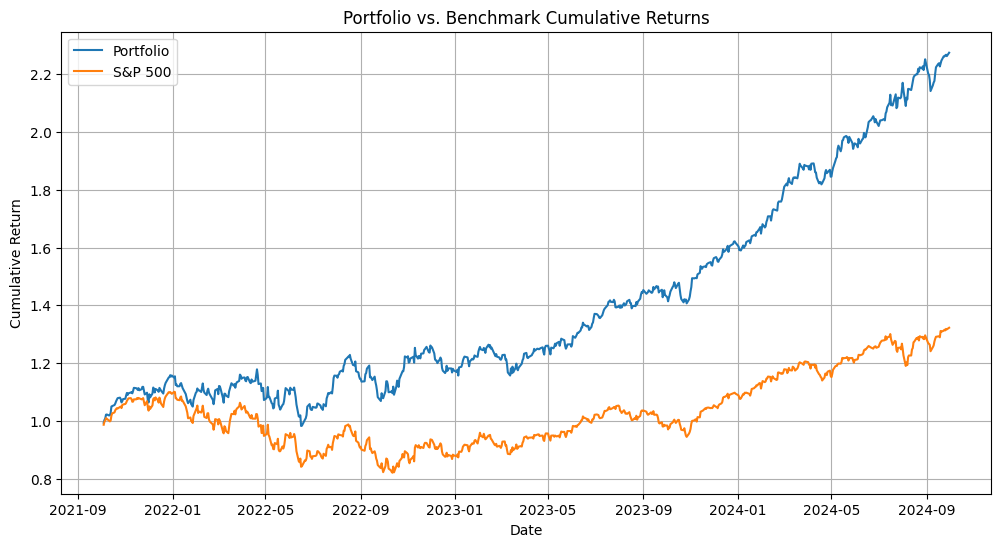

In [564]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Portfolio Return'], label='Portfolio')
plt.plot(cumulative_returns.index, cumulative_returns['Benchmark Return'], label='S&P 500')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [565]:
# Calculate annualized return and volatility
trading_days = 252  # Number of trading days in a year

# Portfolio
portfolio_annual_return = portfolio_returns.mean() * trading_days
portfolio_annual_volatility = portfolio_returns.std() * np.sqrt(trading_days)
portfolio_sharpe_ratio = portfolio_annual_return / portfolio_annual_volatility

# Benchmark
benchmark_annual_return = benchmark_returns.mean() * trading_days
benchmark_annual_volatility = benchmark_returns.std() * np.sqrt(trading_days)
benchmark_sharpe_ratio = benchmark_annual_return / benchmark_annual_volatility

# Display the performance metrics
print("Portfolio Performance:")
print(f"Annualized Return: {portfolio_annual_return.values[0]:.2%}")
print(f"Annualized Volatility: {portfolio_annual_volatility.values[0]:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe_ratio.values[0]:.2f}")

print("\nBenchmark Performance:")
print(f"Annualized Return: {benchmark_annual_return.values[0]:.2%}")
print(f"Annualized Volatility: {benchmark_annual_volatility.values[0]:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio.values[0]:.2f}")


Portfolio Performance:
Annualized Return: 28.95%
Annualized Volatility: 16.77%
Sharpe Ratio: 1.73

Benchmark Performance:
Annualized Return: 10.92%
Annualized Volatility: 17.58%
Sharpe Ratio: 0.62


After seeing the results above, I wanted to relate it to actual dollar value to see the potential of this application.
I started at the beginning with a $10,000 investment in both for comparison, $500 in each of the 20 stocks of the diversified portfolio or a one time $10,000 investment in the S&P 500.

Final Portfolio Value: $22,741.49
Final Benchmark Value (S&P 500): $13,225.68


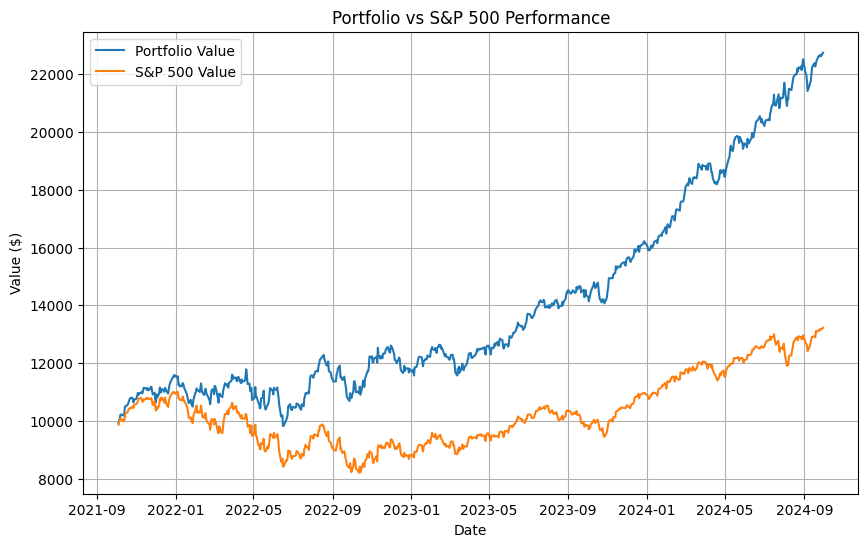

In [566]:
# Total investment in portfolio: $500 in each stock for a total of $10,000
initial_investment_per_stock = 500
total_investment_portfolio = initial_investment_per_stock * num_stocks  # Should equal $10,000 for 20 stocks

# Multiply cumulative returns by the initial investment per stock
portfolio_value = portfolio_cumulative_returns * total_investment_portfolio

# Initial investment in S&P 500: $10,000
initial_investment_benchmark = 10000

# Multiply cumulative returns by the initial investment for S&P 500
benchmark_value = benchmark_cumulative_returns * initial_investment_benchmark

# Display the final portfolio and benchmark value at the end of the backtest period
final_portfolio_value = portfolio_value.iloc[-1].values[0]
final_benchmark_value = benchmark_value.iloc[-1].values[0]

print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Final Benchmark Value (S&P 500): ${final_benchmark_value:,.2f}")

# Plot the growth of the portfolio and benchmark over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.plot(benchmark_value, label='S&P 500 Value')
plt.title('Portfolio vs S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()


### Conclusion
The portfolio backtesting results demonstrate that the diversified stock portfolio significantly outperformed the S&P 500 over the three-year period. Starting with an initial investment of $10,000 (with $500 allocated to each stock), the portfolio grew to $22,741.49, compared to the $13,225.68 value of the S&P 500. This performance reflects an impressive annualized return of 28.95% for the portfolio, nearly three times higher than the S&P 500’s return of 10.92%. The portfolio also achieved a higher Sharpe Ratio of 1.73, indicating better risk-adjusted returns compared to the benchmark's Sharpe Ratio of 0.62, despite slightly lower volatility (16.77% versus 17.58%).

In conclusion, the portfolio demonstrates a well-balanced approach to growth and risk, outperforming the broader market with more efficient returns per unit of risk taken. This highlights the importance of diversification across sectors and selecting stocks that align with the desired risk and growth profiles, which in this case yielded better returns than investing solely in the S&P 500. The results suggest that a diversified, equal-weighted strategy may offer superior performance in certain market conditions, making it a compelling option for investors looking to maximize growth while managing volatility effectively.

For future updates, I plan to incorporate user age as an additional input to tailor the portfolio selection further, emphasizing dividend-paying stocks for older users as part of a long-term strategy. This will allow the tool to align more closely with user preferences based on life stage and financial goals. Additionally, I will explore other unsupervised learning approaches, such as hierarchical clustering and Gaussian Mixture Models, to determine if these methods can further enhance portfolio diversification and performance by identifying more nuanced stock groupings. These updates aim to refine the tool's predictive accuracy and long-term growth potential, especially for users focused on dividends and low-risk growth.